In [101]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.lines import Line2D

Import raw data from local drive. 

In [102]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [103]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [104]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft', 'Unnamed: 13']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Position,Species,Size_cm,Count,Species.1,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,Benthic,SSER,25.0,1,RVAC,Olive rockfish,Intermediate,2.2,High
1,2,Pre-Kelp,0_hours,Mid-Column,SMYS,15.0,6,SATR,Blue rockfish,Midcolumn,2.2,High
2,2,Pre-Kelp,0_hours,Mid-Column,SMYS,20.0,6,EJAC,Blue rockfish,Midcolumn,2.2,High
3,2,Post-Kelp,1_hour,Mid-Column,SMYS,5.0,1,SMEL,Blue rockfish,Midcolumn,2.2,High
4,2,Post-Kelp,1_hour,Mid-Column,SMYS,15.0,4,NaN,Blue rockfish,Midcolumn,2.2,High
...,...,...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,NaN,HDEC,30.0,1,NaN,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,NaN,OPIC,15.0,1,NaN,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,NaN,OPIC,5.0,1,NaN,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,NaN,ELAT,15.0,11,NaN,Striped surfperch,Intermediate,1.5,High


Calculate total abundance, density, richness, biodiversity, and weighted size by transect and mobility cateogry. 

In [105]:
# Compute Weighted Size
fish_master['Weighted_Size_cm'] = fish_master['Size_cm'] * fish_master['Count']

# Group by Transect, Treatment Time and calculate relevant statistics
aggregated = fish_master.groupby(['Transect_Number', 'Treatment_Time']).agg(
    total_abundance=('Count', 'sum'),
    total_density=('Count', lambda x: x.sum() / 20),  # Assuming 20 is the unit area/space, adjust as necessary
    total_weighted_size=('Weighted_Size_cm', 'sum'),
    total_richness=('Species', 'nunique')
).reset_index()

# Define Shannon Index function
def shannon_diversity(group):
    species_counts = group['Count']
    proportions = species_counts / species_counts.sum()
    return -(proportions * np.log(proportions)).sum()

# Apply Shannon Index for biodiversity
shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time']).apply(
    shannon_diversity
).reset_index(name='total_biodiversity')

# Merge Shannon index results into the main stats DataFrame
fish_stats = aggregated.merge(shannon, on=['Transect_Number', 'Treatment_Time'], how='left')

# Optionally, calculate species-level statistics like the average mobility type for each transect and treatment time
species_mobility = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Species'])['Mobility'].first().reset_index()

# Merge mobility data back if necessary
fish_stats = fish_stats.merge(species_mobility, on=['Transect_Number', 'Treatment_Time'], how='left')


C:\Users\FELAB\AppData\Local\Temp\ipykernel_17364\2201591720.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time']).apply(


In [106]:
def compute_statistics(df, column_name, metric_prefix):
    stats = df.groupby(['Treatment_Time', 'Mobility'])[column_name].agg(
        mean_value='mean',
        std_value='std',
        count_value='size'
    ).reset_index()

    stats.rename(columns={
        'mean_value': f'mean_{metric_prefix}',
        'std_value': f'std_{metric_prefix}',
        'count_value': f'count_{metric_prefix}'
    }, inplace=True)

    stats[f'std_error_{metric_prefix}'] = stats[f'std_{metric_prefix}'] / np.sqrt(stats[f'count_{metric_prefix}'])

    return stats

density_stats       = compute_statistics(fish_stats, 'total_density', 'density')
biodiversity_stats  = compute_statistics(fish_stats, 'total_biodiversity', 'biodiversity')
size_stats          = compute_statistics(fish_stats, 'total_weighted_size', 'size')
richness_stats      = compute_statistics(fish_stats, 'total_richness', 'richness')

richness_stats

,Treatment_Time,Mobility,mean_richness,std_richness,count_richness,std_error_richness
0,0_hours,Benthic,4.500000,1.211060,16,0.302765
1,0_hours,Intermediate,4.300000,1.251666,10,0.395811
2,0_hours,Midcolumn,3.818182,1.662419,11,0.501238
3,1_hour,Benthic,5.550000,1.431782,20,0.320156
4,1_hour,Intermediate,5.181818,1.662419,11,0.501238
5,1_hour,Midcolumn,4.545455,2.339386,11,0.705351
6,1_week,Benthic,5.066667,0.703732,15,0.181703
7,1_week,Intermediate,4.444444,1.130388,9,0.376796
8,1_week,Midcolumn,4.428571,1.272418,7,0.480929


In [107]:
metrics_to_melt = ['total_density', 'total_richness', 
                   'total_biodiversity', 'total_weighted_size'] 

melted_df = pd.melt(fish_stats, id_vars=['Transect_Number', 'Treatment_Time', 'Mobility'], 
                    value_vars=metrics_to_melt, 
                    var_name='Metric', value_name='Value')

In [108]:
def run_two_way_anova(stats, metric_column):
    # Run the two-way ANOVA with interaction between Treatment Time and Relief Category
    model = ols(f'Value ~ C(Treatment_Time) * C(Mobility)', data=stats[stats['Metric'] == metric_column]).fit()
    anova_table = anova_lm(model, typ=2)  # Type II Sum of Squares
    print(f"\nANOVA Results for {metric_column}:")
    print(anova_table)
    return anova_table

def run_tukey_hsd(stats, metric_column):
    data = stats[stats['Metric'] == metric_column].copy()
    data['Group'] = data['Treatment_Time'].astype(str) + '_' + data['Mobility'].astype(str)
    
    tukey = pairwise_tukeyhsd(data['Value'], data['Group'], alpha=0.05)
    print(f"\nTukey's HSD Results for {metric_column}:")
    print(tukey.summary())
    return tukey


# Run Two-Way ANOVA and Tukey's HSD for each metric
for metric in metrics_to_melt:
    print(f"\n### Analyzing {metric} ###")
    run_two_way_anova(melted_df, metric)
    run_tukey_hsd(melted_df, metric)



### Analyzing total_density ###

ANOVA Results for total_density:
                                  sum_sq     df         F    PR(>F)
C(Treatment_Time)               3.167587    2.0  2.555529  0.082664
C(Mobility)                     0.250996    2.0  0.202497  0.817019
C(Treatment_Time):C(Mobility)   1.095493    4.0  0.441908  0.778042
Residual                       62.594934  101.0       NaN       NaN

Tukey's HSD Results for total_density:
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
     0_hours_Benthic 0_hours_Intermediate    0.005    1.0  -1.001  1.011  False
     0_hours_Benthic    0_hours_Midcolumn   0.3455 0.9698  -0.632 1.3229  False
     0_hours_Benthic       1_hour_Benthic   0.6075 0.3517 -0.2296 1.4446  False
     0_hours_Benthic  1_hour_Intermediate   0.3864 0.9422 -0.5911 1.3638 

In [109]:
def plot_statistics_with_simple_error_bars(stats, y_column, y_label, metric_name):
    plt.figure(figsize=(10, 6))

    # Mapping for Treatment_Time labels
    treatment_label_map = {
        '0_hours': 'Pre-Kelp',
        '1_hour': 'Post-Kelp (1 Hour)',
        '1_week': 'Post-Kelp (1 Week)'
    }

    # Apply mapping to DataFrame
    stats = stats.copy()
    stats['Treatment_Label'] = stats['Treatment_Time'].map(treatment_label_map)

    # Set treatment order and labels
    treatment_times = ['0_hours', '1_hour', '1_week']
    treatment_labels = [treatment_label_map[t] for t in treatment_times]

    # Custom mobility order and colors
    mobility_categories = ['Benthic', 'Intermediate', 'Midcolumn']
    colors = sns.color_palette("colorblind", len(mobility_categories))

    width = 0.25
    legend_labels = []

    for j, mobility in enumerate(mobility_categories):
        for i, treatment_time in enumerate(treatment_times):
            subset = stats[(stats['Treatment_Time'] == treatment_time) & 
                           (stats['Mobility'] == mobility)]

            if subset.empty:
                continue

            row = subset.iloc[0]
            bar_x = i + j * width
            mean_value = row[y_column]
            std_error = row[f'std_error_{metric_name}']

            plt.bar(bar_x, mean_value, width=width, color=colors[j])
            plt.errorbar(bar_x, mean_value, yerr=std_error, fmt='none',
                         color='black', capsize=5, elinewidth=1)

        legend_labels.append(mobility)

    # Set x-axis
    base_x = np.arange(len(treatment_times))
    center_offset = (width * (len(mobility_categories) - 1)) / 2
    plt.xticks(base_x + center_offset, treatment_labels)

    plt.xlabel('Treatment Time')
    plt.ylabel(y_label)

    # Create legend in correct order
    legend_handles = [Line2D([0], [0], color=colors[j], lw=6) for j in range(len(mobility_categories))]
    plt.legend(legend_handles, legend_labels, title='Mobility')

    plt.tight_layout()
    filename = f'{metric_name}_treatmentxmobility_plot.jpg'
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
    plt.show()
    print(f"Figure saved as {filename}")


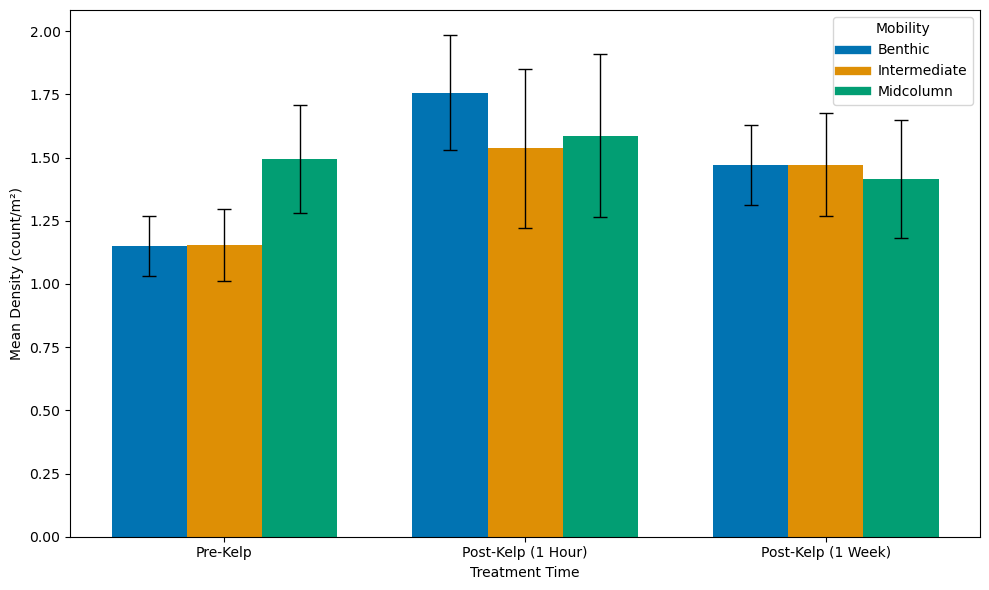

Figure saved as density_treatmentxmobility_plot.jpg


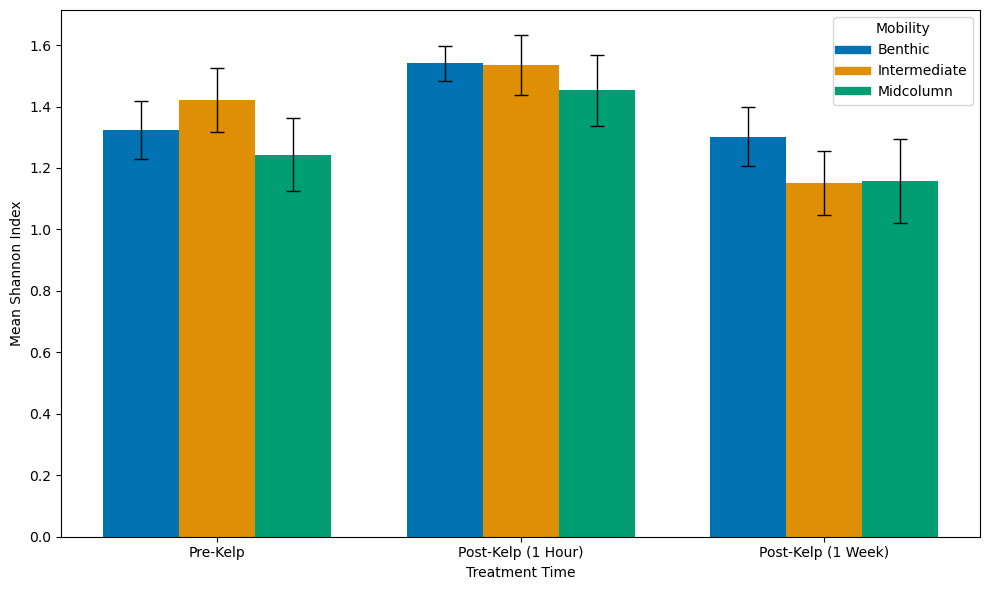

Figure saved as biodiversity_treatmentxmobility_plot.jpg


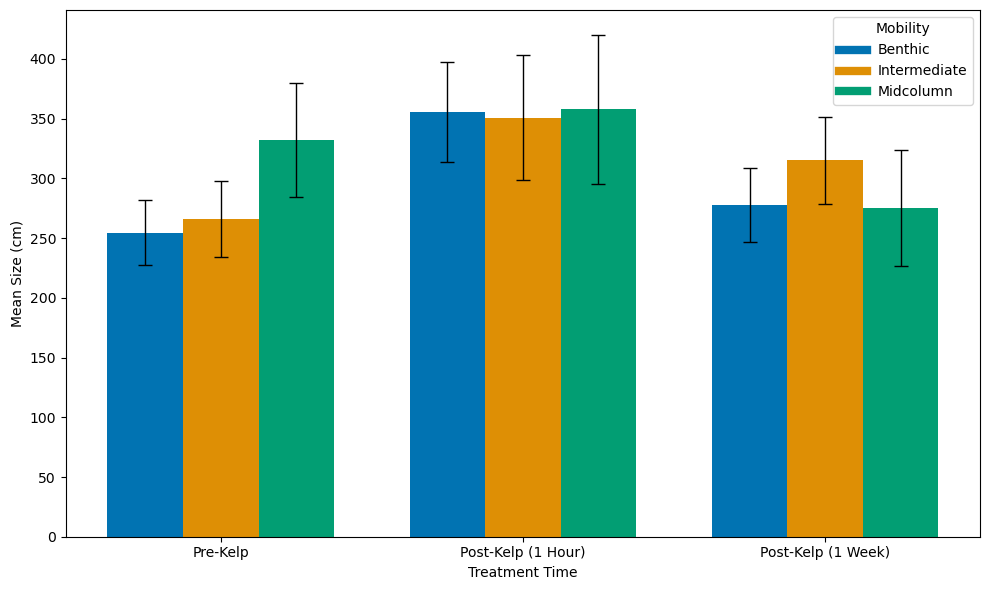

Figure saved as size_treatmentxmobility_plot.jpg


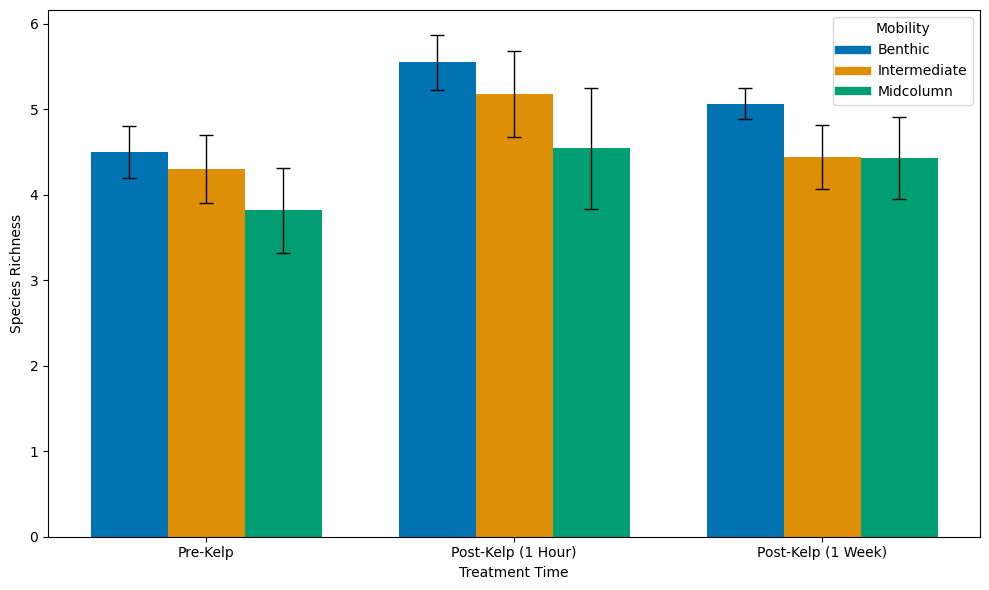

Figure saved as richness_treatmentxmobility_plot.jpg


In [110]:
plot_statistics_with_simple_error_bars(density_stats, 'mean_density', 'Mean Density (count/m²)', 'density')
plot_statistics_with_simple_error_bars(biodiversity_stats, 'mean_biodiversity', 'Mean Shannon Index', 'biodiversity')
plot_statistics_with_simple_error_bars(size_stats, 'mean_size', 'Mean Size (cm)', 'size')
plot_statistics_with_simple_error_bars(richness_stats, 'mean_richness', 'Species Richness', 'richness')